In [16]:
import random
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from api.definer.instruments import *
from api.definer.linear import LinearRegressionModel

import matplotlib as mpl
mpl.style.use('default')

In [17]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.random.manual_seed(random_state)

print('Set random seed:{}'.format(random_state))

Set random seed:0


## Initial Gamma Hedging Strategy

In [18]:
upper = 5
sample = 100

w_pp = 0.125
w_pf = 0.25

print("Long a squared power perpetual with a weight of {}".format(w_pp))
print("Short a perpetual future with a weight of {}".format(w_pf))

Long a squared power perpetual with a weight of 0.125
Short a perpetual future with a weight of 0.25


In [19]:
pu = 3  # upper bound / initial price
pl = 0.5  # lower bound / initial price

print('Set price range for liquidity allocation as [{}, {}]'.format(pl, pu))

Set price range for liquidity allocation as [0.5, 3]


In [20]:
x = np.linspace(0, upper, sample)

y = []  # impermanent loss with concentrated liquidity
for i in x:
    if i < pl:
        y.append((np.sqrt(pl) + i / np.sqrt(pl) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
    elif i > pu:
        y.append((i / np.sqrt(pu) + np.sqrt(pu) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
    else:
        y.append((2 * np.sqrt(i) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
        
pp = x ** 2 - 1  # payoff from power perpetual
pf = x - 1  # payoff from perpetual future

h_gamma = w_pp * pp - w_pf * pf  # gamma-neutral hedge

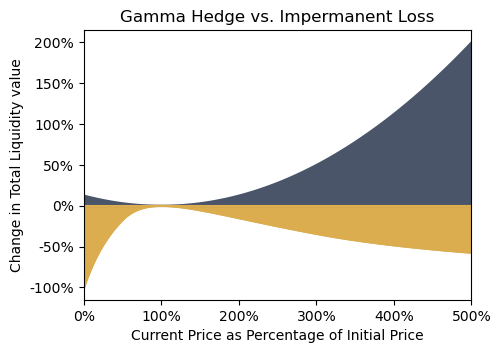

In [21]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

plt.plot(x, h_gamma, color='#4B5569')
plt.axhline(color='#4B5569')

plt.plot(x, y, color='#DBAD4F')
plt.axhline(color='#DBAD4F')

# ax.set_ylim(-1.05, 0.75)
plt.xlim(0, upper)

ax.fill_between(x, 0, h_gamma, color='#4B5569')
ax.fill_between(x, 0, y, color='#DBAD4F')

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Gamma Hedge vs. Impermanent Loss')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

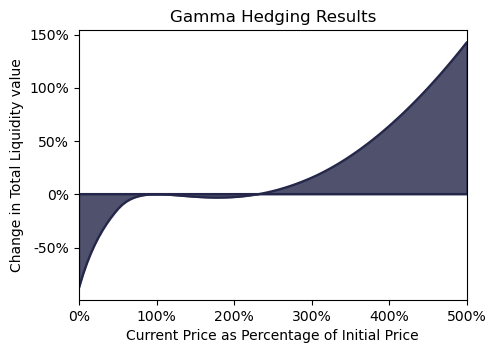

In [22]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

y_new = h_gamma + y

plt.plot(x, y_new, color='#242749')
plt.axhline(color='#242749')

# ax.set_ylim(-0.45, 0.25)
plt.xlim(0, upper)

ax.fill_between(x, 0, y_new, color='#242749', alpha=0.8)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Gamma Hedging Results')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge_loss.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

## Collecting Options for Delta-Gamma Hedging Strategy

In [23]:
currency = 'ETH'
options = retrieve_deribit_options(currency=currency)
print('Total of {} instruments for {} available on Deribit'.format(len(options), currency))
df_options = pd.DataFrame(options)
df_options[['currency', 'expire_date', 'strike_price', 'option_type']] = (
    df_options.instrument_name.str.split('-', expand=True))
df_options

Total of 688 instruments for ETH available on Deribit


,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,ask_price,bid_price,instrument_name,last,low,high,currency,expire_date,strike_price,option_type
0,0.00075,2220.29,9.84,ETH,1704695287627,ETH,0.0,4.0,ETH-26JAN24,2240.420000,...,0.0009,0.0006,ETH-26JAN24-1200-P,0.0011,0.0011,0.0011,ETH,26JAN24,1200,P
1,NaN,2220.29,0.00,ETH,1704695287627,ETH,0.0,0.0,ETH-12JAN24,2224.460000,...,0.1785,NaN,ETH-12JAN24-2550-P,0.0755,NaN,NaN,ETH,12JAN24,2550,P
2,0.03100,2220.29,0.00,ETH,1704695287627,ETH,0.0,0.0,ETH-23FEB24,2265.090000,...,0.0315,0.0305,ETH-23FEB24-2800-C,0.0360,NaN,NaN,ETH,23FEB24,2800,C
3,NaN,2220.29,0.00,ETH,1704695287627,ETH,0.0,0.0,SYN.ETH-10JAN24,2222.358524,...,0.1560,NaN,ETH-10JAN24-1950-C,NaN,NaN,NaN,ETH,10JAN24,1950,C
4,0.23500,2220.29,175271.62,ETH,1704695287627,ETH,0.0,391.0,ETH-29MAR24,2291.900000,...,0.2875,0.1825,ETH-29MAR24-2000-C,0.1995,0.1995,0.2005,ETH,29MAR24,2000,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,NaN,2220.29,0.00,ETH,1704695287642,ETH,0.0,0.0,SYN.ETH-9JAN24,2221.307786,...,NaN,NaN,ETH-9JAN24-2850-P,NaN,NaN,NaN,ETH,9JAN24,2850,P
684,NaN,2220.29,0.00,ETH,1704695287642,ETH,0.0,0.0,SYN.ETH-8JAN24,2220.257048,...,NaN,NaN,ETH-8JAN24-2800-P,NaN,NaN,NaN,ETH,8JAN24,2800,P
685,0.42875,2220.29,0.00,ETH,1704695287642,ETH,0.0,0.0,ETH-23FEB24,2265.090000,...,0.4370,0.4205,ETH-23FEB24-1300-C,NaN,NaN,NaN,ETH,23FEB24,1300,C
686,NaN,2220.29,0.00,ETH,1704695287642,ETH,0.0,0.0,ETH-27DEC24,2455.330000,...,NaN,NaN,ETH-27DEC24-7500-P,NaN,NaN,NaN,ETH,27DEC24,7500,P


In [24]:
p0 = df_options.estimated_delivery_price.mean()
x = np.linspace(0, upper, sample)
x_list = []

for i in df_options.index:
    c = float(df_options.iloc[i]['ask_price'] * p0)
    k = float(df_options.iloc[i]['strike_price'])
    if df_options.iloc[i]['option_type'] == 'C':
        yl = (np.maximum(0, x * p0 - k) - c) / p0
        # ys = (c - np.maximum(0, x * p0 - k)) / p0
    else:
        yl = (np.maximum(0, k - x * p0) - c) / p0
        # ys = (c - np.maximum(0, k - x * p0)) / p0
    x_list.append(yl)
    # x_list.append(ys)

In [25]:
mat_X = np.array(x_list)
mat_X = mat_X[~np.isnan(mat_X).any(axis=1)]  # remove options with nan payoff
mat_X = np.unique(mat_X, axis=0)  # remove duplicates

print('Total of {} valid and unique option candidates'.format(mat_X.shape[0]))

Total of 491 valid and unique option candidates


## Linear Regression with Stochastic Gradient Descent

In [26]:
X = torch.from_numpy(mat_X.transpose())
Y = torch.from_numpy(-y_new)
X = X.float()
Y = Y.float()

# Instantiate the model
input_size = X.shape[1]
model = LinearRegressionModel(input_size)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [27]:
progress = tqdm(range(5000))

for epoch in progress:
    epoch_loss = 0
    optimizer.zero_grad()
    for i in range(int(sample / upper * 2)):
        predictions = model(X[i])

        mse_loss = criterion(predictions, Y[i].unsqueeze(0))
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters()) * 0.05
        loss = mse_loss + l2_reg
        
        epoch_loss += loss.item()
        # # Backward pass and optimization
        # optimizer.zero_grad()
        loss.backward()

    optimizer.step()
    progress.set_postfix_str(round(epoch_loss, 4))

100%|██████████| 5000/5000 [01:14<00:00, 67.45it/s, 0.0656]


In [28]:
w = model.linear.weight.data.numpy()  # weights assigned to each option

## Strategy Visualization

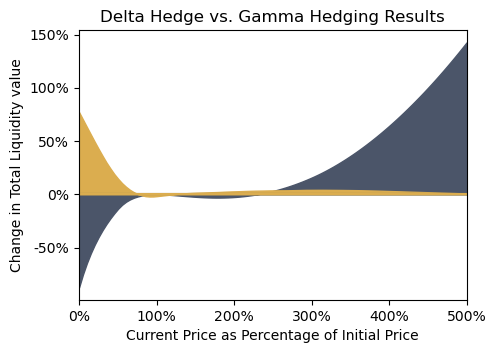

In [29]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

# ax.set_ylim(-1.05, 0.75)
plt.xlim(0, upper)

x = np.linspace(0, upper, sample)
h_gamma_delta = np.matmul(mat_X.transpose(), np.array(w).transpose())

# plt.plot(x, y_new, color='#4B5569')
plt.axhline(color='#4B5569')

# plt.plot(x, h, color='#DBAD4F')
plt.axhline(color='#DBAD4F')

# ax.set_ylim(-1.05, 0.75)
plt.xlim(0, upper)

ax.fill_between(x, 0, y_new, color='#4B5569')
ax.fill_between(x, 0, h_gamma_delta.transpose().tolist()[0], color='#DBAD4F')

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Delta Hedge vs. Gamma Hedging Results')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

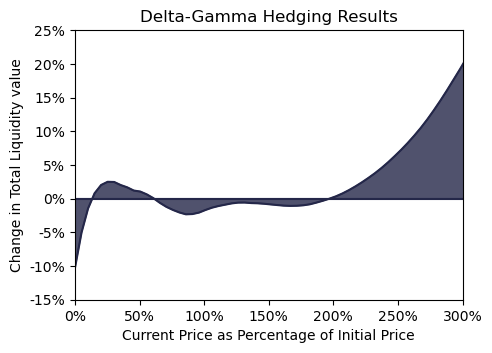

In [30]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

plt.plot(x, h_gamma_delta.transpose().tolist()[0] + y_new, color='#242749')
plt.axhline(color='#242749')

ax.set_ylim(-0.15, 0.25)
plt.xlim(0, 3)

ax.fill_between(x, 0, h_gamma_delta.transpose().tolist()[0] + y_new, color='#242749', alpha=0.8)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Delta-Gamma Hedging Results')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge_loss.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()